# 基本训练循环

在本指南将把之前学到的张量、变量、梯度带和模块这些内容结合在一起来训练模型。
当然TensorFlow包含更高级的神经网络API--tf.Keras API--它提供了有用的抽象来减少引用。
但是，在本指南中，我们从基本原理入手开始介绍神经网络训练，以建立坚实的基础。

### 引入

In [2]:
import tensorflow as tf

### 解决机器学习步骤

解决一个机器学习问题通常包括以下步骤:  
    1：获取训练数据  
    2：定义模型  
    3：定义损失函数  
    4：运行训练数据，计算损失   
    5：计算损失梯度，并使用优化器optimizer 调整变量来训练数据。  
    6：评估结果

此篇指南先用简单的线性结构来演示一个简单的线性结构-- f(x)= x*W + b --此式只有 W 和 b两个变量  
这是最基本的机器学习问题即给定x和y，试着通过简单的线性回归求出直线的斜率和偏移量。
    

### 数据

监督学习使用输入(通常表示为x)和输出(表示为y，通常称为标签)。  
我们的目标是通过从成对的输入和输出中学习，然后预测达到由输入值即可预测输出值的效果。  
在TensorFlow中，数据的每个输入几乎都用一个张量tensor来表示，通常是一个向量vector。在监督训练中，输出也是一个张量tensor。  
下面的数据是 由直线加高斯噪声得到的：

In [24]:

TRUE_W = 3.0
TRUE_B = 2.0

NUM_EXAMPLES = 1000

# 按照正态分布随机产生形状为（1000，）的tensor
x = tf.random.normal(shape=[NUM_EXAMPLES])

# 按照正态分布随机产生形状为（1000，）噪声
noise = tf.random.normal(shape=[NUM_EXAMPLES])

# 计算y
y = x * TRUE_W + TRUE_B + noise

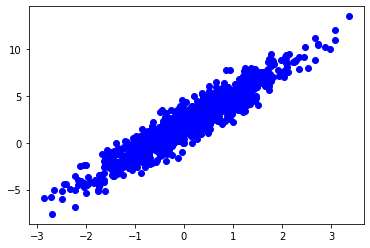

In [25]:
# 图形化展示数据
import matplotlib.pyplot as plt

plt.scatter(x, y, c="b")
plt.show()

张量通常成批地聚集在一起，或将一组输入和输出堆叠在一起。
以batch作为单位训练有很多好处，可以很好进行优化和矢量化计算。
鉴于上面建造的数据集非常小，也可以将整个数据集视为一个batch处理。

### 定义模型

使用tf.variables来表示模型中的所有权重。varible构造函数要求变量有初始值，该变量可以是任何类型和形状的张量；
定义之后变量的类型和形状是固定的。可以使用其中一个assign（）赋值方法更改值。

使用tf.model来封装变量和计算，采用python对象可以简单保存。

In [26]:
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # 初始化变量
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.w * x + self.b

model = MyModel()

# 打印出变量
print("Variables:", model.variables)

# 验证模型
assert model(3.0).numpy() == 15.0

Variables: (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=5.0>)


初始变量在这里是以固定的方式设置的，但是Keras也自带了一系列的初始化方法（对Keras层设置初始化权重的方法）可供使用

### 定义损失函数

损失函数可以衡量输入模型的输出与目标输出的匹配程度。两者差别当然是越小越好。若定义标准L2损失，也称为“均方”误差，其实例代码如下:

In [79]:
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))

在对模型进行训练之前，可以将模型的预测用红色表示，训练数据用蓝色表示，从而使损失值可视化:

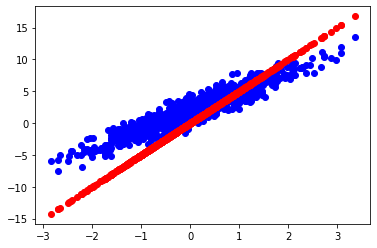

Current loss: 8.422477


In [28]:
plt.scatter(x, y, c="b")
plt.scatter(x, model(x), c="r")
plt.show()

print("Current loss: %1.6f" % loss(model(x), y).numpy())

### 定义一个训练循环

训练循环由重复执行三个任务组成，依次为:  
1：把一批输入数据喂入模型得到输出  
2：通过计算输出与labels的loss  
3:  梯度下降更新梯度  
4：用梯度优化向量

梯度下降训练过程--
-在tf.train.Optimizer实现中拥有许多梯度下降方案的变体；本着从基本原理构建的精神使用tf.GradientTape我们自己来实现最基本的梯度过程，tf.assign_sub用于值递减计算

In [70]:
def train(model, x, y, learning_rate):

  with tf.GradientTape() as t:
    #可训练变量由GradientTape自动追踪
    current_loss = loss(y, model(x))

  # 计算W和b的梯度
  dw, db = t.gradient(current_loss, [model.w, model.b])

  # 减去由学习率缩放的梯度
  model.w.assign_sub(learning_rate * dw)
  model.b.assign_sub(learning_rate * db)

为查看效果，也可以输送相同batch的x和y，来查看w和b是如何变化的：

In [71]:
model = MyModel()

# 记录下w  b 的值
Ws, bs = [], []
epochs = range(10)

# 定义循环
def training_loop(model, x, y):

  for epoch in epochs:
    # 使用同批次更新模型
    train(model, x, y, learning_rate=0.1)

    # 更新模型之前追踪
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())
    current_loss = loss(y, model(x))

    print("Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f" %
          (epoch, Ws[-1], bs[-1], current_loss))


Starting: W=5.00 b=0.00, loss=8.42248
Epoch  0: W=4.62 b=0.37, loss=5.89875
Epoch  1: W=4.31 b=0.67, loss=4.23763
Epoch  2: W=4.07 b=0.91, loss=3.14428
Epoch  3: W=3.86 b=1.11, loss=2.42462
Epoch  4: W=3.70 b=1.27, loss=1.95092
Epoch  5: W=3.57 b=1.40, loss=1.63913
Epoch  6: W=3.46 b=1.50, loss=1.43389
Epoch  7: W=3.38 b=1.59, loss=1.29880
Epoch  8: W=3.31 b=1.66, loss=1.20988
Epoch  9: W=3.25 b=1.72, loss=1.15134


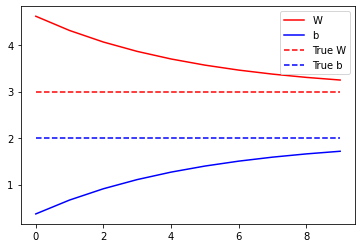

In [72]:
print("Starting: W=%1.2f b=%1.2f, loss=%2.5f" %
      (model.w.numpy(), model.b.numpy(), loss(y, model(x)).numpy()))

# 训练
training_loop(model, x, y)

# 图像展示
plt.plot(epochs, Ws, "r",
         epochs, bs, "b")

plt.plot([TRUE_W] * len(epochs), "r--",
         [TRUE_B] * len(epochs), "b--")

plt.legend(["W", "b", "True W", "True b"])
plt.show()


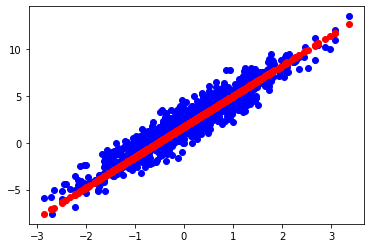

Current loss: 1.151342


In [73]:
# 打印出模型的性能
plt.scatter(x, y, c="b")
plt.scatter(x, model(x), c="r")
plt.show()

print("Current loss: %1.6f" % loss(model(x), y).numpy())

### 使用keras进行相同的操作：

如果子类化tf.keras.Model，那么定义模型看起来是完全一样的。请记住，Keras模型最终继承自模块。

In [74]:
class MyModelKeras(tf.keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    # I初始化 w b 
    # 实际操作中 变量的值是随机初始化的
    self.w = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x, **kwargs):
    return self.w * x + self.b

keras_model = MyModelKeras()

# R开始训练
training_loop(keras_model, x, y)

# 保存检查点
keras_model.save_weights("my_checkpoint")

Epoch  0: W=4.62 b=0.37, loss=5.89875
Epoch  1: W=4.31 b=0.67, loss=4.23763
Epoch  2: W=4.07 b=0.91, loss=3.14428
Epoch  3: W=3.86 b=1.11, loss=2.42462
Epoch  4: W=3.70 b=1.27, loss=1.95092
Epoch  5: W=3.57 b=1.40, loss=1.63913
Epoch  6: W=3.46 b=1.50, loss=1.43389
Epoch  7: W=3.38 b=1.59, loss=1.29880
Epoch  8: W=3.31 b=1.66, loss=1.20988
Epoch  9: W=3.25 b=1.72, loss=1.15134


训练循环函数没有必要每次构建模型训练都写 可以使用Keras的内置特性 作为一种快捷方法

此时需要使用model.compile()设置参数，使用model.fit()进行训练。使用L2 loss 和梯度下降的Keras实现可以减少代码，这也是一种快捷方式。Keras损失和优化器也可以在这些函数之外使用，前面的示例也可以使用它们。

In [78]:
keras_model = MyModelKeras()

keras_model.compile(
    # 通常情况, fit() uses tf.function().  
    # 可以在调试时把它关掉，但现在它是打开的
    run_eagerly=False,

    # 使用内置优化器，配置为对象
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),

    # Keras带有内置的MSE
    # 也可以使用上面定义的损失函数
    loss=tf.keras.losses.mean_squared_error,
)

Keras fit期望成批的数据或NumPy数组形式的完整数据集，NumPy数组被分割成批，默认批大小为32。

In [76]:
print(x.shape[0])
keras_model.fit(x, y, epochs=10, batch_size=1000)#开始训练

1000
Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 3s 3ms/sample - loss: 8.4225
Epoch 2/10
1000/1000 [==============================] - 0s 8us/sample - loss: 5.8988
Epoch 3/10
1000/1000 [==============================] - 0s 8us/sample - loss: 4.2376
Epoch 4/10
1000/1000 [==============================] - 0s 3us/sample - loss: 3.1443
Epoch 5/10
1000/1000 [==============================] - 0s 4us/sample - loss: 2.4246
Epoch 6/10
1000/1000 [==============================] - 0s 4us/sample - loss: 1.9509
Epoch 7/10
1000/1000 [==============================] - 0s 6us/sample - loss: 1.6391
Epoch 8/10
1000/1000 [==============================] - 0s 7us/sample - loss: 1.4339
Epoch 9/10
1000/1000 [==============================] - 0s 4us/sample - loss: 1.2988
Epoch 10/10
1000/1000 [==============================] - 0s 4us/sample - loss: 1.2099


注意Keras打印训练后的损失，而不是训练前的损失，所以第一次损失看起来更低，但除此之外，这显示了基本相同的训练性能。